In [1]:
import sys
import os

def set_project_root(root_dir):
    """
    Set the project root directory for imports and change the current working directory.

    Args:
        root_dir (str): The path to the project's root directory.
    """
    # Make sure the provided path is an absolute path
    root_dir = os.path.abspath(root_dir)

    # Set the project root directory for imports
    if root_dir not in sys.path:
        sys.path.append(root_dir)

    # Change the current working directory to the project root
    os.chdir(root_dir)

set_project_root("/Users/ryant/Documents/GitHub/options-driven-forecasting")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz
import os


df_spot = pd.read_parquet("./src/data/spot/BINANCE_BTCUSDT_1h_010621_123124.parquet")
df_spot['datetime'] = pd.to_datetime(df_spot['timestamp'], unit='ms')
df_spot['returns'] = df_spot['close'] / df_spot['close'].shift(1) - 1
df_spot['log_returns'] = np.log(df_spot['close'] / df_spot['close'].shift(1))
df_spot

,timestamp,open,high,low,close,volume,datetime,returns,log_returns
0,1.622506e+12,37253.82,37894.81,37100.00,37798.31,5234.072735,2021-06-01 00:00:00,NaN,NaN
1,1.622509e+12,37798.32,37803.49,37160.00,37196.64,3154.434156,2021-06-01 01:00:00,-0.015918,-0.016046
2,1.622513e+12,37196.64,37296.08,36620.00,36850.00,3078.850158,2021-06-01 02:00:00,-0.009319,-0.009363
3,1.622516e+12,36850.00,37124.09,36478.00,36704.99,3179.701359,2021-06-01 03:00:00,-0.003935,-0.003943
4,1.622520e+12,36706.80,36957.69,36561.89,36748.01,1767.107527,2021-06-01 04:00:00,0.001172,0.001171
...,...,...,...,...,...,...,...,...,...
22645,1.704053e+12,42619.04,42680.36,42504.56,42558.01,1015.140350,2023-12-31 20:00:00,-0.001432,-0.001433
22646,1.704056e+12,42558.02,42670.44,42520.72,42520.72,923.438130,2023-12-31 21:00:00,-0.000876,-0.000877
22647,1.704060e+12,42520.73,42591.10,42056.00,42257.88,1811.594110,2023-12-31 22:00:00,-0.006181,-0.006201
22648,1.704064e+12,42257.89,42345.65,42066.00,42283.58,1710.137210,2023-12-31 23:00:00,0.000608,0.000608


# Exploratory Data Analysis


1. First start with the OHLC data
   1. Returns Distribution
      1. Kernel Density Estimation
      2. Normal Plot / Half Normal Plot / QQ Plot
      3. Boxplots
   2. Transformation
      1. Log 
      2. Box Cox
   3. Understanding how returns are like over time: Z - score / Rolling Z - score / Bollinger Band 
   4. Relationship between returns and volume
   5. Intraday Volatility: Volatility, adjusted for intraday 
   6. Boxplots?


1. Brief Description
   1. Topics
      1. Stationarity
      2. Volatility
   2. Plots
      1. Normal Plot / Half Normal Plot / QQ Plot
      2. Boxplot
2. Distribution
   1. Topics
      1. Skew / Symmetric / Normal / Heavier or Lighter tails
      2. What degrees of freedom matches the underlying?
      3. What parametric models provide a good fit?
      4. Bandwidth for the distribution?
   2. Plots
      1. Transformation KDE


## Exploration Tools
- Histogram
- Kernal Density Estimation
- Normal Probability Plots / Half-Normal Plots / QQ Plots
- Test of normality
- Boxplots
- Geometry
- Transformation of KDE

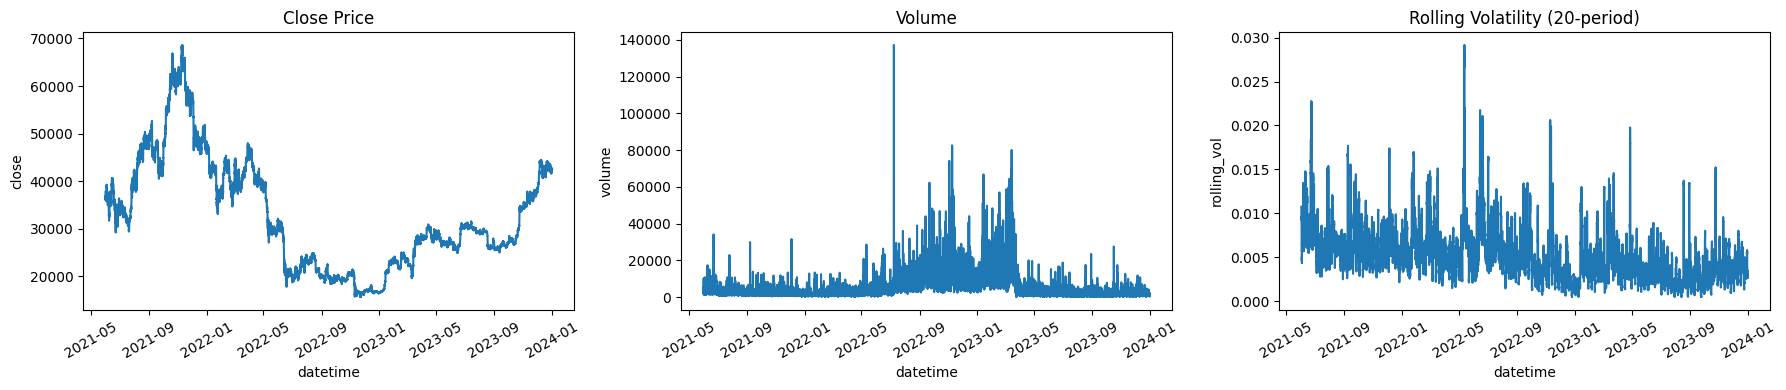

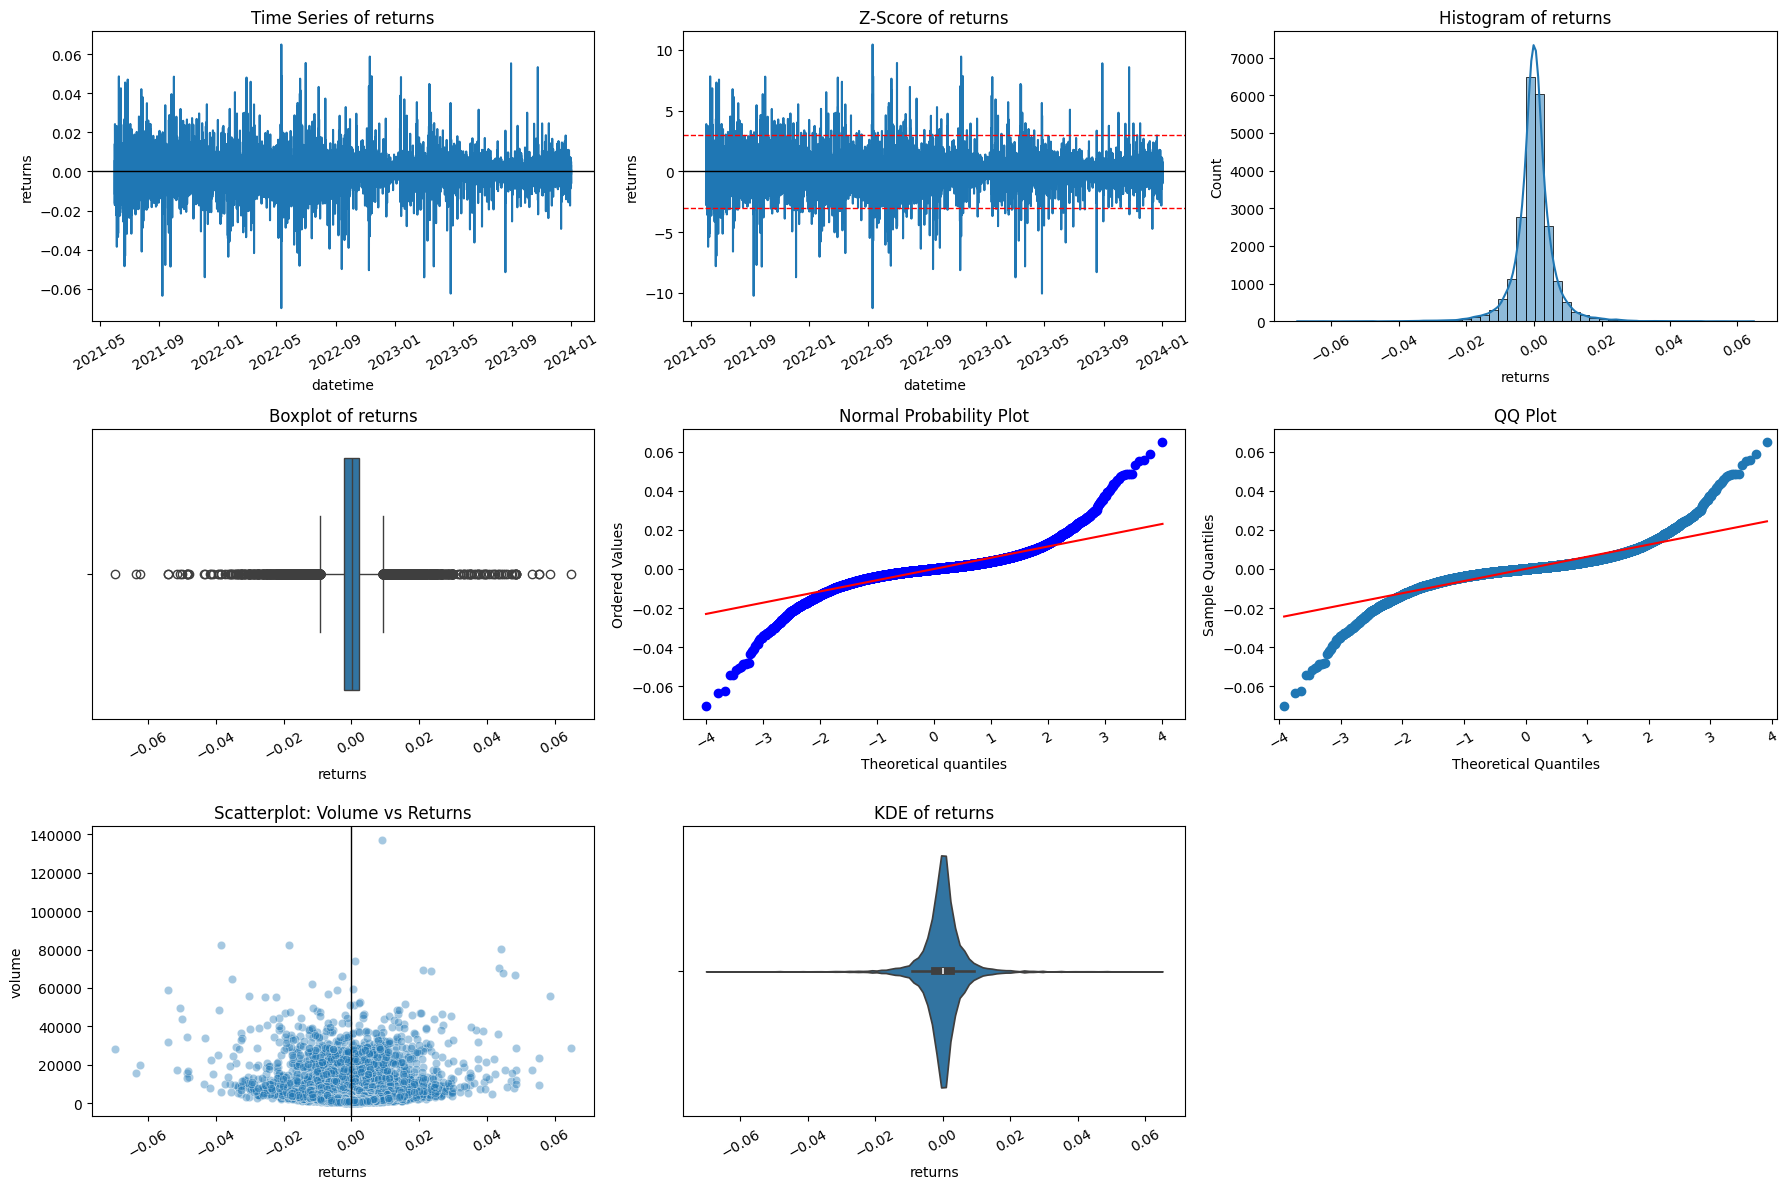

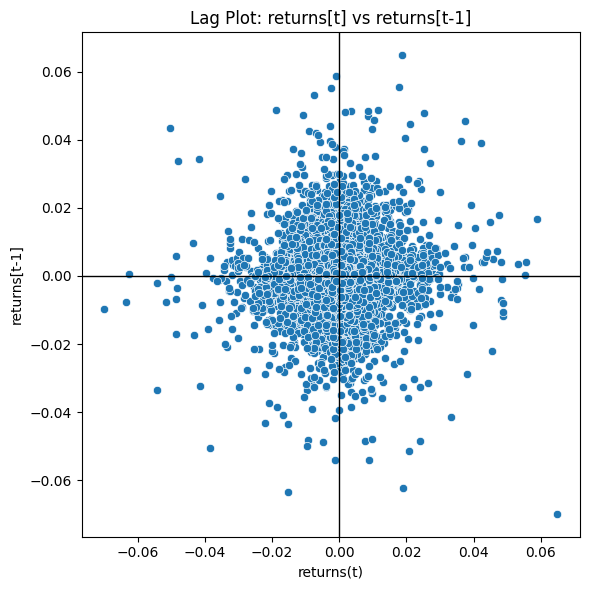

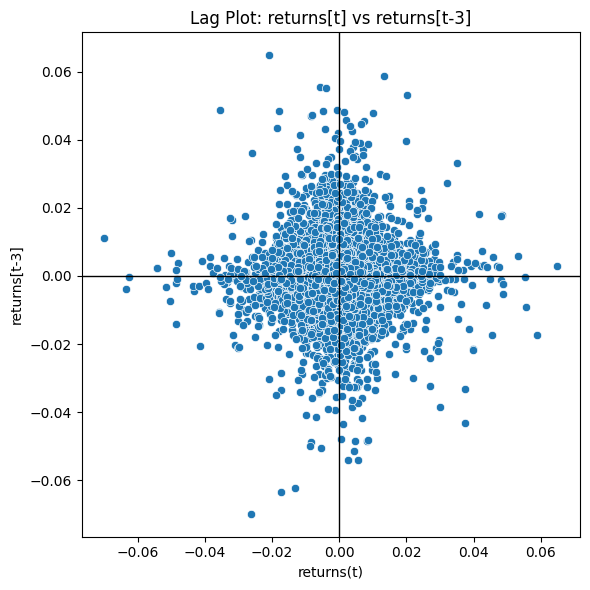

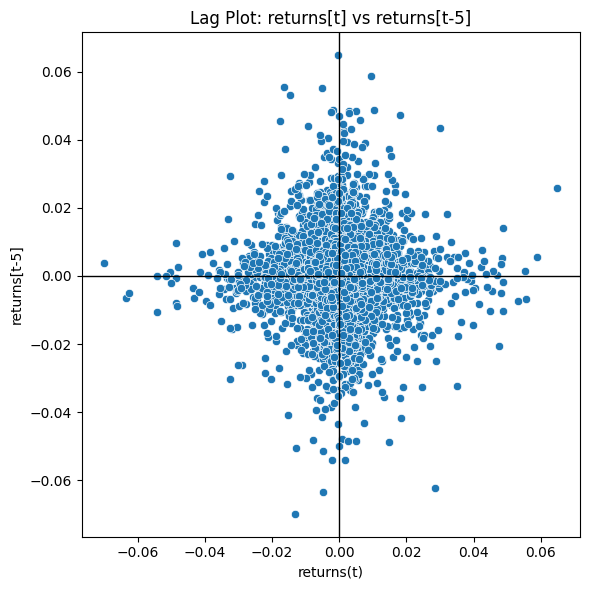

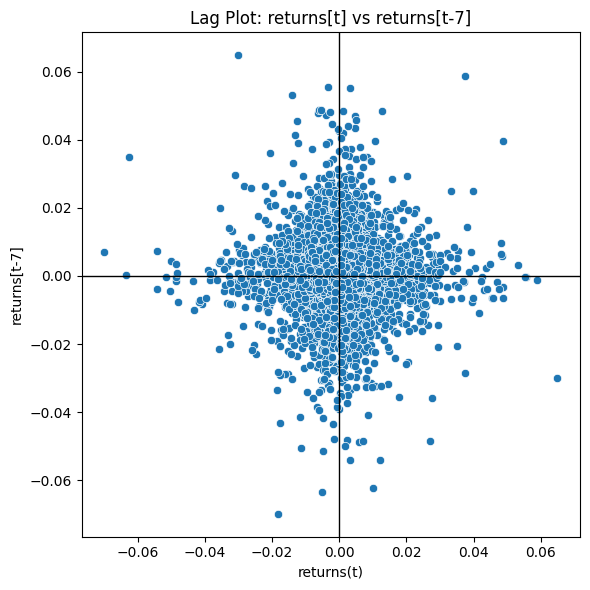

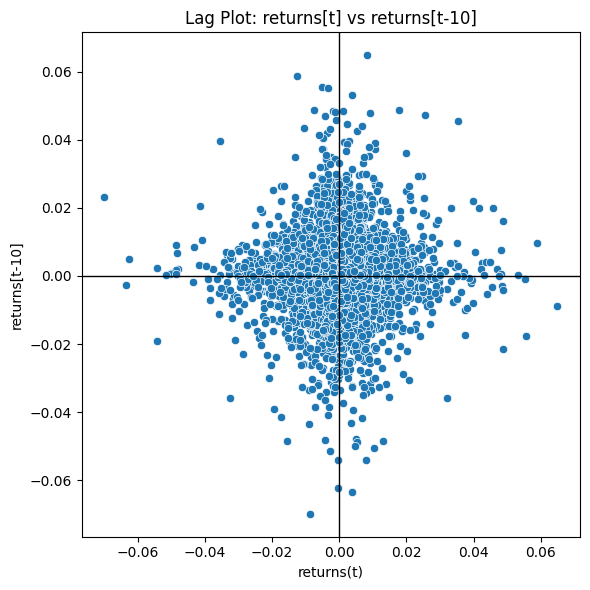

In [77]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

"""
statsmodels: regression, linear models, time series analysis, extensions to topics also covered by scipy.stats.
Pandas: tabular data, time series functionality, interfaces to other statistical languages.
PyMC: Bayesian statistical modeling, probabilistic machine learning.
scikit-learn: classification, regression, model selection.
Seaborn: statistical data visualization.
rpy2: Python to R bridge.
"""

class OHLCVDataExplorer:
    def __init__(self, df, returns_col = 'close'):
        """
        OHLCVDataExplorer is a class for exploring and visualizing OHLCV (Open, High, Low, Close, Volume) data.

        Args:
            df (pd.DataFrame): A DataFrame containing OHLCV data with a datetime index. columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']. timestamp should be in ms.

        """
        self.df = df
        self.df['datetime'] = pd.to_datetime(self.df['timestamp'], unit='ms')
        self.df['returns'] = self.df[returns_col] / self.df[returns_col].shift(1) - 1
        self.df['log_returns'] = np.log(self.df['close'] / self.df['close'].shift(1))        

    # 1 Exploration
    def plot_ts(self):
        """
        Plot time series of close price, volume, and rolling volatility using datetime.
        """
        
        # Compute rolling volatility of log returns
        self.df['rolling_vol'] = self.df['log_returns'].rolling(window=20).std()

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharex=False)

        # Plot Close
        data_close = self.df[['datetime', 'close']].dropna()
        sns.lineplot(data=data_close, x='datetime', y='close', ax=axes[0])
        axes[0].set_title('Close Price')

        # Plot Volume
        data_vol = self.df[['datetime', 'volume']].dropna()
        sns.lineplot(data=data_vol, x='datetime', y='volume', ax=axes[1])
        axes[1].set_title('Volume')

        # Plot Rolling Volatility
        data_vol = self.df[['datetime', 'rolling_vol']].dropna()
        sns.lineplot(data=data_vol, x='datetime', y='rolling_vol', ax=axes[2])
        axes[2].set_title('Rolling Volatility (20-period)')

        for ax in axes:
            ax.tick_params(axis='x', rotation=30)

        plt.tight_layout()
        plt.show()


    def plot_returns(self, column):
        """
        Plot returns diagnostics: time series, z-score, histogram, boxplot, normal plot, QQ plot, volume scatterplot, KDE.
        
        Args:
            column (str): Return-type column to analyse (e.g., 'returns' or 'log_returns')
        """
        data = self.df[['datetime', column, 'volume']].dropna()
        z_scores = (data[column] - data[column].mean()) / data[column].std()

        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
        axes = axes.flatten()

        # 1. Time series of returns
        sns.lineplot(data=data, x='datetime', y=column, ax=axes[0])
        axes[0].set_title(f'Time Series of {column}')
        axes[0].axhline(0, color='black', lw=1)
        # 2. Z-score plot
        sns.lineplot(x=data['datetime'], y=z_scores, ax=axes[1])
        axes[1].axhline(0, color='black', lw=1)
        axes[1].axhline(3, color='red', linestyle='--', lw=1)
        axes[1].axhline(-3, color='red', linestyle='--', lw=1)
        axes[1].set_title(f'Z-Score of {column}')

        # 3. Histogram
        sns.histplot(data[column], bins=50, kde=True, ax=axes[2])
        axes[2].set_title(f'Histogram of {column}')

        # 4. Boxplot
        sns.boxplot(x=data[column], ax=axes[3], orient='h')
        axes[3].set_title(f'Boxplot of {column}')

        # 5. Normal probability plot
        stats.probplot(data[column], dist="norm", plot=axes[4])
        axes[4].set_title('Normal Probability Plot')

        # 6. QQ plot
        qqplot(data[column], line='s', ax=axes[5])
        axes[5].set_title('QQ Plot')

        # 7. Volume vs Returns scatterplot
        sns.scatterplot(data=data, x=column, y='volume', ax=axes[6], alpha=0.4)
        axes[6].set_title('Scatterplot: Volume vs Returns')
        axes[6].axvline(0, color='black', lw=1)
        # 8. KDE plot
        sns.violinplot(data[column], fill=True, ax=axes[7], density_norm='count', orient = 'h', bw_adjust=0.2)
        axes[7].set_title(f'KDE of {column}')

        # 9. Empty or placeholder
        axes[8].axis('off')

        for ax in axes[:8]:
            ax.tick_params(axis='x', rotation=30)

        plt.tight_layout()
        plt.show()

    def test_stationarity(self, column, confidence_level=0.05):
        """
        Perform Augmented Dickey-Fuller test for stationarity.

        Args:
            column (str): Return-type column to test (e.g., 'returns' or 'log_returns')
        """
        from statsmodels.tsa.stattools import adfuller

        result = adfuller(self.df[column].dropna())
        print(f"ADF Statistic: {result[0]}")
        print(f"p-value: {result[1]}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"\t{key}: {value}")
        if result[1] < confidence_level:
            print(f"The time series is stationary (p-value < {confidence_level})")
        else:
            print(f"The time series is non-stationary (p-value >= {confidence_level})")
        return result
    def plot_lag(self, lags=[1, 3, 5, 7, 10]):
        for lag in lags:
            plt.figure(figsize=(6, 6))
            sns.scatterplot(x=self.df['returns'], y=self.df['returns'].shift(lag))
            plt.title(f'Lag Plot: returns[t] vs returns[t-{lag}]')
            plt.xlabel(f'returns(t)')
            plt.ylabel(f'returns[t-{lag}]')
            plt.axhline(0, color='black', lw=1)
            plt.axvline(0, color='black', lw=1)
            plt.tight_layout()
            plt.show()

ohlcv_data = OHLCVDataExplorer(df_spot)
ohlcv_data.plot_ts()
ohlcv_data.plot_returns('returns')
ohlcv_data.plot_lag()